In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import GaussianBlur

from brightness import dino
from brightness.tone_mappers.aces import aces

def tensor_rgb_to_xyz(image):
    rgb_to_xyz_matrix = torch.Tensor(
        [
            [0.4124564, 0.3575761, 0.1804375],
            [0.2126729, 0.7151522, 0.0721750],
            [0.0193339, 0.1191920, 0.9503041],
        ]
    ).to(image.device)
    xyz = image @ rgb_to_xyz_matrix.T
    return xyz[..., 0], xyz[..., 1], xyz[..., 2]


def pytorch_gaussian_blur(image, sigma):
    blur = GaussianBlur(kernel_size=int(2 * sigma + 1) | 1, sigma=sigma)
    if len(image.size()) < 3:
        image = image.unsqueeze(0)
    return blur(image).squeeze()


def pytorch_dn_brightness_model(
    L: torch.Tensor,
    cs_ratio: float = 2.0,
    min_scale: float = 1.0,
    w: float = 0.85,
    a: float = 1.0,
    b: float = 1.0,
    c: float = 1.0,
    d: float = 1.0,
    scale_normalized_constants: bool = False,
) -> torch.Tensor:
    max_scale = min(*L.size())
    scale = max_scale / cs_ratio
    scales = []
    while scale >= min_scale:
        scales.insert(0, scale)
        scale /= cs_ratio
    weights = [w**i for i in range(len(scales))]
    # Initialize weighted_sum as a 2D array
    weighted_sum = torch.zeros(L.size()[:2]).to(L.device)
    # Compute ratios and weighted sum using only two blurred images at a time
    center_response = pytorch_gaussian_blur(L, scales[0])
    for i in range(1, len(scales)):
        surround_response = pytorch_gaussian_blur(L, scales[i])
        assert center_response.ndim == 2
        assert surround_response.ndim == 2
        _b = b
        _d = d
        if scale_normalized_constants:
            _b /= scales[i] ** 2
            _d /= scales[i] ** 2
        weighted_sum += weights[i - 1] * (
            (a * center_response + _b) / (c * surround_response + _d) - _b / _d
        )
        center_response = surround_response
    return weighted_sum


class ACESModel(nn.Module):
    W = 0.9
    A = 1
    B = 1
    C = 1
    D = 1
    SCALE_NORMALIZED = True
    
    def __init__(self):
        super(ACESModel, self).__init__()
        # a, b, c, d, e
        self.weights = nn.Parameter(torch.rand(4))

    def forward(self, x):
        a, b, d, e = self.weights
        tonemapped_x = torch.squeeze(aces(x, a, b, a, d, e)) # c = a
        X, Y, Z = tensor_rgb_to_xyz(tonemapped_x)
        L, _, _ = dino.xyz_to_lxy(X, Y, Z)
        brightness_response = pytorch_dn_brightness_model(
            L,
            w=self.W,
            a=self.A,
            b=self.B,
            c=self.C,
            d=self.D,
            scale_normalized_constants=self.SCALE_NORMALIZED,
        )
        return brightness_response.unsqueeze(0)

In [2]:
from pathlib import Path

import cv2
import numpy as np
from tqdm.auto import tqdm


def file_to_brightness(file_path):
    image = dino.read_image(file_path)
    X, Y, Z = dino.rgb_to_xyz(image)
    L, _, _ = dino.xyz_to_lxy(X, Y, Z)
    return dino.dn_brightness_model(
        L,
        w=ACESModel.W,
        a=ACESModel.A,
        b=ACESModel.B,
        c=ACESModel.C,
        d=ACESModel.D,
        scale_normalized_constants=ACESModel.SCALE_NORMALIZED,
    )


# Generate brightness response images for all inputs
data_dir = Path("training")
for file in tqdm(list((data_dir / "images").iterdir()), desc="generating training set"):
    try:
        export_path = str(data_dir / "brightnesses" / file.stem) + ".npy"
        if Path(export_path).exists():
            print(f"{export_path} already exists, skipping...")
            continue
            
        brightness = file_to_brightness(str(file))
        print(f"Exporting {export_path}")
        np.save(export_path, brightness)
    except Exception as e:
        print(f"File {file} could not be processed due to {e}")

generating training set:   0%|          | 0/8 [00:00<?, ?it/s]

training/brightnesses/CadikNight.npy already exists, skipping...
training/brightnesses/CadikDesk.npy already exists, skipping...
training/brightnesses/CadikWindow.npy already exists, skipping...
training/brightnesses/LuxoDoubleChecker.npy already exists, skipping...
training/brightnesses/HDRMark.npy already exists, skipping...
training/brightnesses/GeneralGrant.npy already exists, skipping...
training/brightnesses/DelicateArch.npy already exists, skipping...
training/brightnesses/507.npy already exists, skipping...


In [3]:
class BrightnessDataset(torch.utils.data.Dataset):

    def __init__(self, input_dir, target_dir, max_width=1000, transform=None, target_transform=None):
        self.input_file_paths = sorted(f for f in Path(input_dir).iterdir() if f.is_file())
        self.target_file_paths = sorted(f for f in Path(target_dir).iterdir() if f.is_file())

        assert all(
            self.input_file_paths[i].stem == self.target_file_paths[i].stem
            for i in range(len(self.input_file_paths))
        )

        self.max_width = max_width
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.input_file_paths)

    def __getitem__(self, idx):
        input_image = dino.read_image(str(self.input_file_paths[idx]))
        input_image = dino.resize_image(
            input_image, resize_width=self.max_width
        )
        if self.transform:
            input_image = self.transform(input_image)
            
        brightness_response = np.load(self.target_file_paths[idx])
        brightness_response = dino.resize_image(
            brightness_response, resize_width=self.max_width
        )
        if self.target_transform:
            brightness_response = self.target_transform(brightness_response)

        return input_image, brightness_response


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device is {device}")
model = ACESModel().to(device)
optim = torch.optim.Adam(model.parameters())
loss_fn = nn.MSELoss()

train_set = BrightnessDataset("training/images", "training/brightnesses")
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True)

Device is cuda


In [7]:
CHECKPOINT_PATH = Path("training/checkpoints")

def checkpoint_file_path(epoch):
    return str(CHECKPOINT_PATH / f"aces-epoch{epoch}.pickle")

start_epoch = 245
if start_epoch == 0:
    checkpoint = dict(
        state_dict={},
        train_losses=[],
        train_errors=[],
    )
else:
    checkpoint = torch.load(checkpoint_file_path(start_epoch), weights_only=False)
    model.load_state_dict(checkpoint["state_dict"])
    print(f"Loaded model from checkpoint at epoch {start_epoch}.")

e = start_epoch

Loaded model from checkpoint at epoch 245.


In [7]:
max_epochs = 500

while e < max_epochs:
    train_losses = []
    for sample, brightness in tqdm(train_loader, desc=f"Epoch {e}"):
        sample = sample.to(device)
        brightness = brightness.float().to(device)
        prediction = model(sample)
        loss = loss_fn(prediction, brightness)
        train_losses.append(loss.detach().cpu().item())
        optim.zero_grad()
        loss.backward()
        optim.step()

        # CMAP = "viridis"
        # fig, axs = plt.subplots(1,2,figsize=(12,6))
        # target = np.squeeze(brightness.detach().cpu().numpy())
        # pred = np.squeeze(prediction.detach().cpu().numpy())
        # vmin = np.min(pred)
        # vmax = np.max(pred)
        # im = axs[0].imshow(target, vmin=vmin, vmax=vmax, cmap=CMAP)
        # axs[0].set_title("Original Brightness")
        # axs[1].imshow(pred, vmin=vmin, vmax=vmax, cmap=CMAP)
        # axs[1].set_title("ACES Brightness")
        # fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)

    checkpoint["state_dict"] = model.state_dict()
    checkpoint["train_losses"].append(np.mean(train_losses))
    checkpoint["train_errors"].append([np.min(train_losses), np.max(train_losses)])
    torch.save(checkpoint, checkpoint_file_path(e))
    print(f"Average training loss: {checkpoint["train_losses"][-1]}")
    e += 1

Epoch 57:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.01516168293892406


Epoch 58:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.014829656662186608


Epoch 59:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.014559462462784722


Epoch 60:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.014212819514796138


Epoch 61:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.01396532979561016


Epoch 62:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.013663996156537905


Epoch 63:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.013419144408544526


Epoch 64:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.013171153899747878


Epoch 65:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.012924703682074323


Epoch 66:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.012690475792624056


Epoch 67:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.012480227800551802


Epoch 68:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.012250673113157973


Epoch 69:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.012074288388248533


Epoch 70:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.011901755642611533


Epoch 71:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.01171130032162182


Epoch 72:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.011571972194360569


Epoch 73:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.011446161341154948


Epoch 74:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.011305264342809096


Epoch 75:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.01116379801533185


Epoch 76:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.011038412223570049


Epoch 77:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.010963684413582087


Epoch 78:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.010839045338798314


Epoch 79:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.010764932027086616


Epoch 80:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.01068734805448912


Epoch 81:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.010630196193233132


Epoch 82:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.010565976466750726


Epoch 83:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.010502777120564133


Epoch 84:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.010452655842527747


Epoch 85:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.010394818964414299


Epoch 86:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.010361218795878813


Epoch 87:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.01033655513310805


Epoch 88:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.010320429340936244


Epoch 89:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.010263299365760759


Epoch 90:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.010251675179461017


Epoch 91:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.010219983087154105


Epoch 92:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.010189336549956352


Epoch 93:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.010173103539273143


Epoch 94:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.010185101942624897


Epoch 95:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.01016697075101547


Epoch 96:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.010126930195838213


Epoch 97:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.010120783554157242


Epoch 98:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.010105390305398032


Epoch 99:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.010093301330925897


Epoch 100:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.010083586821565405


Epoch 101:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.010067152441479266


Epoch 102:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.0100521111744456


Epoch 103:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.010040162975201383


Epoch 104:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.010028665332356468


Epoch 105:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.010013722028816119


Epoch 106:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.010005991091020405


Epoch 107:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009991894388804212


Epoch 108:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009981205977965146


Epoch 109:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009971137449610978


Epoch 110:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009965804987587035


Epoch 111:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.00995164638152346


Epoch 112:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.00994444132084027


Epoch 113:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009926458180416375


Epoch 114:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009918533643940464


Epoch 115:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009905683691613376


Epoch 116:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009898519201669842


Epoch 117:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.00988195592071861


Epoch 118:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009933685883879662


Epoch 119:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009918891853885725


Epoch 120:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009951480955351144


Epoch 121:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009949520259397104


Epoch 122:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009920624550431967


Epoch 123:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009893825103063136


Epoch 124:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009865719330264255


Epoch 125:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009832034818828106


Epoch 126:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.00981860698084347


Epoch 127:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009811232390347868


Epoch 128:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009802691143704578


Epoch 129:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009789216273929924


Epoch 130:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009786952112335712


Epoch 131:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009790687006898224


Epoch 132:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009775166196050122


Epoch 133:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009762532892636955


Epoch 134:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009755184961250052


Epoch 135:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009748240699991584


Epoch 136:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009743372473167256


Epoch 137:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009745892195496708


Epoch 138:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.00973144473391585


Epoch 139:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009721641341457143


Epoch 140:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009717531385831535


Epoch 141:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009705129341455176


Epoch 142:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.00970254439744167


Epoch 143:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009688811813248321


Epoch 144:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.00969458240433596


Epoch 145:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009676513582235202


Epoch 146:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.00967316993046552


Epoch 147:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009665935358498245


Epoch 148:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009715973632410169


Epoch 149:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009725469397380948


Epoch 150:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009801728068850935


Epoch 151:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009815266646910459


Epoch 152:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009809033828787506


Epoch 153:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.00979404998361133


Epoch 154:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009767747716978192


Epoch 155:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009738936787471175


Epoch 156:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009721530077513307


Epoch 157:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009694546810351312


Epoch 158:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009671959734987468


Epoch 159:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009665923775173724


Epoch 160:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009633463545469567


Epoch 161:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009614535374566913


Epoch 162:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009591927897417918


Epoch 163:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009597303200280294


Epoch 164:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.00958659261232242


Epoch 165:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009580407408066094


Epoch 166:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009584246872691438


Epoch 167:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009566410270053893


Epoch 168:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009568206791300327


Epoch 169:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009557716373819858


Epoch 170:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.00956378661794588


Epoch 171:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009552971343509853


Epoch 172:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009544289816403762


Epoch 173:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009584806655766442


Epoch 174:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009605656610801816


Epoch 175:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.00966247107135132


Epoch 176:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009672648215200752


Epoch 177:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009665025252616033


Epoch 178:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.0096510203438811


Epoch 179:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009633014997234568


Epoch 180:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009608864755136892


Epoch 181:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009590592671884224


Epoch 182:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009575348376529291


Epoch 183:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009555270808050409


Epoch 184:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009532782336464152


Epoch 185:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009516908699879423


Epoch 186:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009499897103523836


Epoch 187:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009490155265666544


Epoch 188:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009499952604528517


Epoch 189:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009497115213889629


Epoch 190:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009495747392065823


Epoch 191:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009489008720265701


Epoch 192:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009472324716625735


Epoch 193:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009491329838056117


Epoch 194:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009522380831185728


Epoch 195:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009559332596836612


Epoch 196:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009569639543769881


Epoch 197:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009560228907503188


Epoch 198:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009550249844323844


Epoch 199:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009533384087262675


Epoch 200:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009509813215117902


Epoch 201:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009503357548965141


Epoch 202:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009480320528382435


Epoch 203:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.00946611593826674


Epoch 204:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009447112708585337


Epoch 205:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009434159466763958


Epoch 206:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009489137271884829


Epoch 207:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009523566317511722


Epoch 208:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009562199033098295


Epoch 209:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009570725436788052


Epoch 210:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009557949670124799


Epoch 211:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.0095444381586276


Epoch 212:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009528349241008982


Epoch 213:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009510345262242481


Epoch 214:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009495497273746878


Epoch 215:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009479155647568405


Epoch 216:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009463769383728504


Epoch 217:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009447629825444892


Epoch 218:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009433240338694304


Epoch 219:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009420203510671854


Epoch 220:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.00940549123333767


Epoch 221:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009398139867698774


Epoch 222:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009396195557201281


Epoch 223:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009387930564116687


Epoch 224:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009393438318511471


Epoch 225:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009387702331878245


Epoch 226:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009383234631968662


Epoch 227:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009384000324644148


Epoch 228:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009372241736855358


Epoch 229:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009377332840813324


Epoch 230:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009367008635308594


Epoch 231:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009373723034514114


Epoch 232:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.00936959619866684


Epoch 233:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009364602476125583


Epoch 234:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009359989082440734


Epoch 235:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.00936329530668445


Epoch 236:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009373601846164092


Epoch 237:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009365617617731914


Epoch 238:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009353226138046011


Epoch 239:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009349532600026578


Epoch 240:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009347227052785456


Epoch 241:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009338576259324327


Epoch 242:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009337181749287993


Epoch 243:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009336556977359578


Epoch 244:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.00933385724783875


Epoch 245:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009332097804872319


Epoch 246:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009323607227997854


Epoch 247:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009330459055490792


Epoch 248:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009316838491940871


Epoch 249:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009314433700637892


Epoch 250:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 1.3818373698741198


Epoch 251:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.00941614416660741


Epoch 252:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.0097644601482898


Epoch 253:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.009896850620862097


Epoch 254:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.010004424373619258


Epoch 255:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.010029236815171316


Epoch 256:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.01004145568003878


Epoch 257:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.010048423951957375


Epoch 258:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.010051650751847774


Epoch 259:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.010052685916889459


Epoch 260:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.010053213190985844


Epoch 261:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.0100533856311813


Epoch 262:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.010053474950836971


Epoch 263:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.010053522884845734


Epoch 264:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.010053543810499832


Epoch 265:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.010053550999145955


Epoch 266:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.010053552250610664


Epoch 267:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.010053551435703412


Epoch 268:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.01005355067900382


Epoch 269:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.010053548845462501


Epoch 270:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.010053547652205452


Epoch 271:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.010053545265691355


Epoch 272:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.010053543228423223


Epoch 273:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.010053541307570413


Epoch 274:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.010053539066575468


Epoch 275:   0%|          | 0/8 [00:00<?, ?it/s]

Average training loss: 0.0100535367091652


Epoch 276:   0%|          | 0/8 [00:00<?, ?it/s]

KeyboardInterrupt: 

[0.14737704 0.17472397 0.75167084 0.96517015]


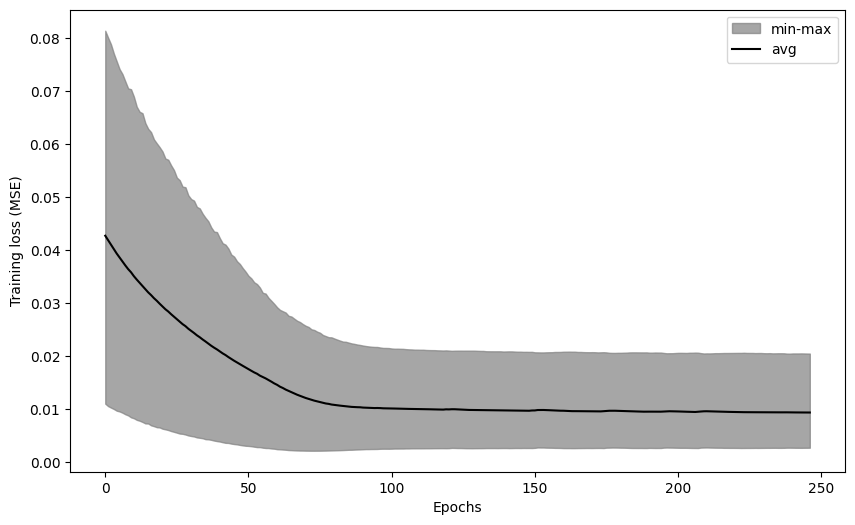

In [8]:
import matplotlib.pyplot as plt

x_range = list(range(len(checkpoint["train_losses"])))
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.set_xlabel("Epochs")
ax.set_ylabel("Training loss (MSE)")
ax.fill_between(
    x_range,
    [y2 for _, y2 in checkpoint["train_errors"]],
    y2=[y1 for y1, _ in checkpoint["train_errors"]],
    color="grey",
    label="min-max",
    alpha=0.7,
)
ax.plot(x_range, checkpoint["train_losses"], "k-", label="avg")
_ = ax.legend()

print(model.weights.detach().cpu().numpy())

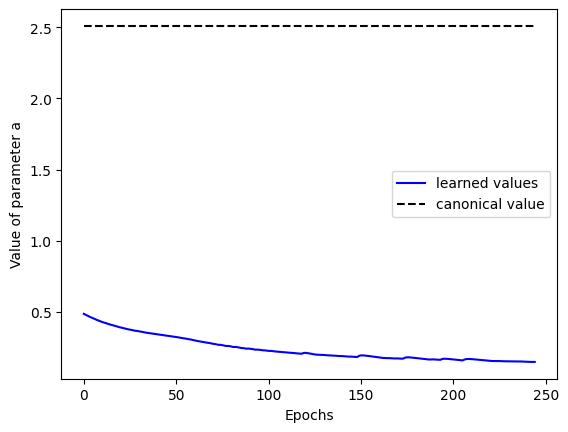

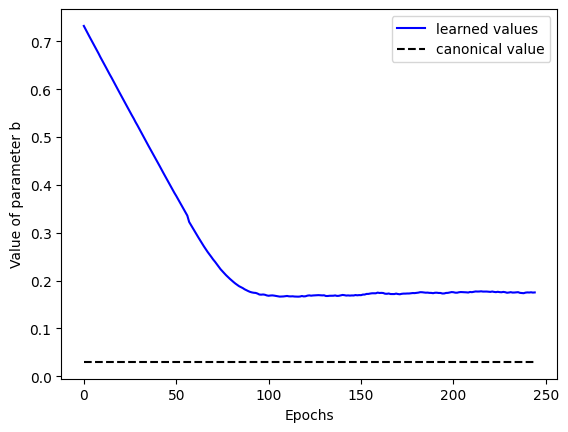

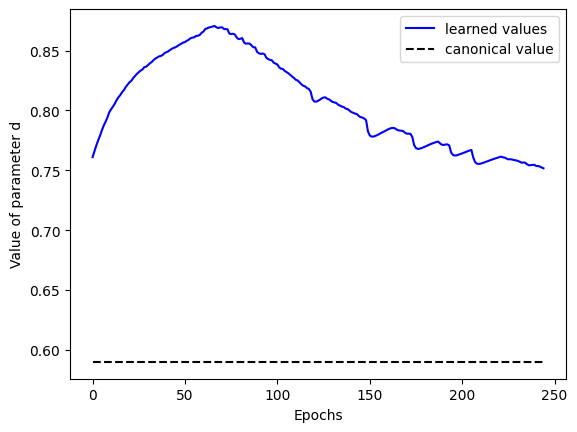

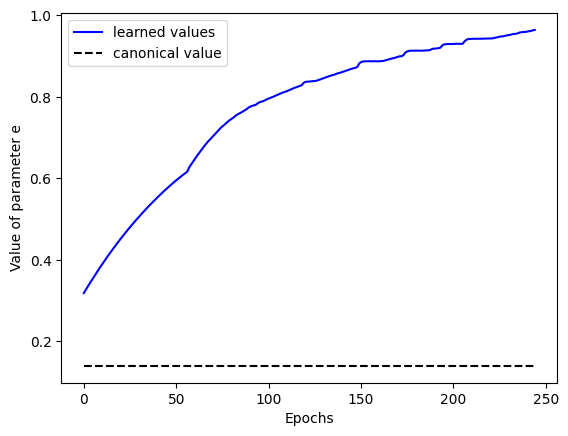

In [11]:
# Compare learning to "canonical" ACES coefficients from
# https://knarkowicz.wordpress.com/2016/01/06/aces-filmic-tone-mapping-curve/
params = ["a", "b", "d", "e"]
canonical_values = dict(zip(params, [2.51, 0.03, 0.59, 0.14]))

learned_params = {p: [] for p in params}
num_epochs = 245
for epoch in range(num_epochs):
    model.load_state_dict(torch.load(checkpoint_file_path(epoch), weights_only=False)["state_dict"])
    for p, value in zip(params, model.weights.detach().cpu().numpy(), strict=True):
        learned_params[p].append(value)

x_values = list(range(num_epochs))
for param, learned_values in learned_params.items():
    fig, ax = plt.subplots()
    ax.set_xlabel("Epochs")
    ax.set_ylabel(f"Value of parameter {param}")
    ax.plot(x_values, learned_values, "b-", label="learned values")
    ax.plot(x_values, [canonical_values[param] for _ in x_values], "k--", label="canonical value")
    ax.legend()

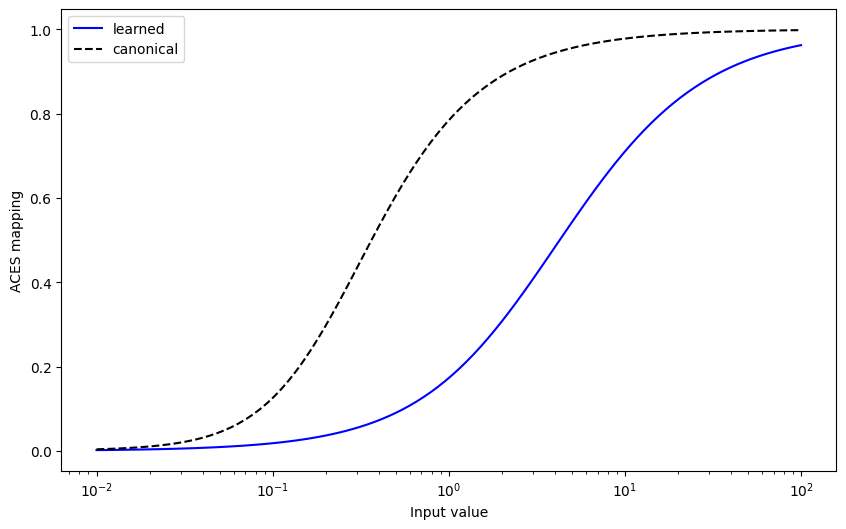

In [15]:
epoch_to_use = 245
model.load_state_dict(torch.load(checkpoint_file_path(epoch_to_use), weights_only=False)["state_dict"])
a, b, d, e = model.weights.detach().cpu().numpy()
ca, cb, cd, ce = list(canonical_values.values())

x_range = np.logspace(-2, 2, num=100, base=10)
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.set_xlabel("Input value")
ax.set_xscale("log")
ax.set_ylabel("ACES mapping")
ax.plot(x_range, aces(x_range, a, b, a, d, e), "b-", label="learned")
ax.plot(x_range, aces(x_range, ca, cb, ca, cd, ce), "k--", label="canonical")
ax.legend()